# Modeling - xPressure

This notebook will work through multiple models and determine which model performs the best.

In [52]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score

import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [53]:
data = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pass_rushers.csv")
data.head()

C:\Users\19012\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (48,50) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,index,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,position,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,isOnOffense,ToLeft,X_std,Y_std,back,left,right,distance_blocker,distance_rusher,pressure,pressure_allowed,edge,interiorDL,LB,T,G,C,interiorOL,num_rushers,los_snap,dist_los_snap,O_std_1,O_std_2,Dir_std_1,Dir_std_2,x_qb,y_qb,dist_qb
0,35,35,263,263,2021090900,97,41263.0,6,2021-09-10T00:26:31.600,90.0,DAL,right,43.30,18.89,0.96,0.90,0.11,316.48,288.76,ball_snap,Pass Rush,LEO,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,False,False,43.30,18.89,36.56,30.92,16.92,3.263817,NaN,1,0,1,0,0,0,0,0,0,5.0,41.56,-1.74,316.48,316.48,288.76,288.76,37.64,24.26,7.802083
1,36,36,264,264,2021090900,97,41263.0,7,2021-09-10T00:26:31.700,90.0,DAL,right,43.19,18.91,1.08,0.86,0.12,308.13,282.13,None,Pass Rush,LEO,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,False,False,43.19,18.91,36.56,30.92,16.92,3.172381,NaN,1,0,1,0,0,0,0,0,0,5.0,41.56,-1.74,308.13,308.13,282.13,282.13,37.56,24.26,7.766557
2,37,37,265,265,2021090900,97,41263.0,8,2021-09-10T00:26:31.800,90.0,DAL,right,43.03,18.93,1.30,0.85,0.16,310.58,277.08,None,Pass Rush,LEO,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,False,False,43.03,18.93,36.56,30.92,16.92,3.059412,NaN,1,0,1,0,0,0,0,0,0,5.0,41.56,-1.74,310.58,310.58,277.08,277.08,37.47,24.25,7.695193
3,38,38,266,266,2021090900,97,41263.0,9,2021-09-10T00:26:31.900,90.0,DAL,right,42.87,18.98,1.48,0.79,0.17,312.75,279.62,None,Pass Rush,LEO,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,False,False,42.87,18.98,36.56,30.92,16.92,2.943739,NaN,1,0,1,0,0,0,0,0,0,5.0,41.56,-1.74,312.75,312.75,279.62,279.62,37.38,24.24,7.603138
4,39,39,267,267,2021090900,97,41263.0,10,2021-09-10T00:26:32.000,90.0,DAL,right,42.60,19.09,2.16,1.34,0.30,312.75,286.29,None,Pass Rush,LEO,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,False,False,42.60,19.09,36.56,30.92,16.92,2.695199,NaN,1,0,1,0,0,0,0,0,0,5.0,41.56,-1.74,312.75,312.75,286.29,286.29,37.27,24.23,7.404627


In [54]:
games = pd.read_csv("C:/Users/19012/Documents/BDB 2023/games.csv")
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN


In [55]:
data.shape

(803594, 91)

In [56]:
players = pd.read_csv("C:/Users/19012/Documents/BDB 2023/players.csv")
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [57]:
plays = pd.read_csv("C:/Users/19012/Documents/BDB 2023/pffScoutingData.csv")
plays.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [58]:
games = pd.read_csv("C:/Users/19012/Documents/BDB 2023/games.csv")
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN


## Train/Test Split

Typically, I'll use the train_test_split function from scikit learn. However, in regards to a tweet from Ron Yurko (https://twitter.com/Stat_Ron/status/1611195293218873344), having a game in both datasets can cause leakage and make our model appear better than it is.

In [59]:
len(data['gameId'].unique())

122

122 games in our dataset. 80/20 split would require 98 games in the training set and 24 games in the test set; therefore, I'll take 3 random games from each week.

In [84]:
test = pd.DataFrame()
for i in games['week'].unique():
    test = test.append(games[games['week']==i].sample(n=3,random_state=42))

In [61]:
# join the games to get the right rows in each table
test = data.merge(test,on='gameId')
# sanity check (should be 20%)
test.shape[0]/data.shape[0]

0.19302160045993375

In [62]:
train = data[~data['gameId'].isin(test['gameId'].unique())]
# sanity check (should be 80%)
train.shape[0]/data.shape[0]

0.8069783995400662

In [63]:
# set index for the model for further evaluation
train = train.set_index(['gameId','nflId','playId','frameId'])

test = test.set_index(['gameId','nflId','playId','frameId'])

In [64]:
features = ['s', 'a', 'dis', 'down', 'yardsToGo', 'defendersInBox', 'pff_playAction', 'X_std', 'Y_std', 'dist_qb', 'num_rushers', 
            'distance_blocker', 
            #'second_closest_offensive_player', 
            'dist_los_snap', 'O_std_2', 'Dir_std_2', 'edge', 'interiorDL', 'LB']
label = 'pressure'

In [65]:
X_train = train[features]
X_test = test[features]
y_train = train[label]
y_test = test[label]

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# sanity check
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train.shape[0]/data.shape[0])

(803594, 91)
(648483, 18)
(648483,)
0.8069783995400662


## Outcome Distribution

The first step I'll take is to observe the distribution of the label (pressure). If there is a class imbalance, then I will use SMOTE to balance the classes. Otherwise, I will leave the label alone.

In [68]:
print('Rows in class 0:',data['pressure'].value_counts()[0]/(data['pressure'].value_counts()[0]+data['pressure'].value_counts()[1]))

Rows in class 0: 0.8830304855436949


The data is imbalanced; therefore, I will use SMOTE to resolve this issue.

In [69]:
X_train.head()

s     a   dis  down  yardsToGo  \
gameId     nflId   playId frameId                                      
2021091200 35452.0 56     6        0.01  0.21  0.01     1         10   
                          7        0.14  1.20  0.03     1         10   
                          8        0.41  1.99  0.05     1         10   
                          9        0.79  2.53  0.08     1         10   
                          10       1.17  2.64  0.12     1         10   

                                   defendersInBox  pff_playAction  X_std  \
gameId     nflId   playId frameId                                          
2021091200 35452.0 56     6                   7.0               1  35.53   
                          7                   7.0               1  35.51   
                          8                   7.0               1  35.48   
                          9                   7.0               1  35.44   
                          10                  7.0               1  35.38   

                                   Y_std   dist_qb  num_rushers  \
gameId     nflId   playId frameId                                 
2021091200 35452.0 56     6        27.01  3.662595          4.0   
                          7        27.04  3.640673          4.0   
                          8        27.08  3.603027          4.0   
                          9        27.15  3.537358          4.0   
                          10       27.25  3.428032          4.0   

                                   distance_blocker  dist_los_snap  O_std_2  \
gameId     nflId   playId frameId                                             
2021091200 35452.0 56     6                1.581455          -0.54   130.42   
                          7                1.562850          -0.54   134.03   
                          8                1.534438          -0.54   132.83   
                          9                1.483543          -0.54   127.84   
                          10               1.421443          -0.54   127.22   

                                   Dir_std_2  edge  interiorDL  LB  
gameId     nflId   playId frameId                                   
2021091200 35452.0 56     6           347.26     1           0   0  
                          7           333.19     1           0   0  
                          8           327.53     1           0   0  
                          9           328.30     1           0   0  
                          10          329.49     1           0   0

In [70]:
for i in X_train.columns:
    if X_train[X_train[i].isna()].shape[0]>0:
        print(i,X_train[X_train[i].isna()].shape)
        X_train[i] = X_train[i].fillna(-1)
    if X_test[X_test[i].isna()].shape[0]>0:
        print(i,X_test[X_test[i].isna()].shape)
        X_test[i] = X_test[i].fillna(-1)

dist_qb (93, 18)
dist_qb (20, 18)
distance_blocker (25, 18)


<ipython-input-70-b1f98b10a5ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = X_train[i].fillna(-1)
<ipython-input-70-b1f98b10a5ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i] = X_test[i].fillna(-1)


In [71]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [72]:
print(X_train.shape)
print(X_res.shape)
print(y_res.shape)

(648483, 18)
(1142448, 18)
(1142448,)


## Create Model

Begin with a naive model that predicts the majority class in the former dataset. This model will be used as the baseline. Then, I will begin to increase the complexity of the models used by first running a logistic regression model, followed by xgboost. The best performing model will be used to create probabilities on the dataset.

In [73]:
# naive model
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="constant",constant=1)
dummy_clf.fit(X_res, y_res)
y_pred = dummy_clf.predict(X_test)
f1_score(y_test, y_pred)

0.1947884176714306

In [74]:
# logistic regression
clf = LogisticRegression(random_state=0,max_iter=100000000).fit(X_res, y_res)
# clf.predict(X[:2, :])
# clf.predict_proba(X[:2, :])
# clf.score(X_test, y_test)

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred)

0.328154604016673

Increasing the model complexity while keeping the model simple improved the score. That's exciting to see especially when I plan to use a more complex model.

In [75]:
# xgboost
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_res, y_res)

y_pred = xgb_model.predict(X_test)

In [76]:
f1_score(y_test, y_pred)

0.31013647695102886

The xgboost outperforms the other models immensely; therefore, I will use the xgboost model to generate pressure probabilities for each pass rusher. First, I will calculate the probability at the frame-level. Then, I will take the average pressure probability.

In [77]:
#Predicting probabilities
prob_val = xgb_model.predict_proba(X_test)[:, 1]

In [78]:
X_test['xPress'] = prob_val
X_test.head()

<ipython-input-78-710e2c54d4c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['xPress'] = prob_val


s     a   dis  down  yardsToGo  \
gameId     nflId   playId frameId                                      
2021090900 41263.0 97     6        0.96  0.90  0.11     3          2   
                          7        1.08  0.86  0.12     3          2   
                          8        1.30  0.85  0.16     3          2   
                          9        1.48  0.79  0.17     3          2   
                          10       2.16  1.34  0.30     3          2   

                                   defendersInBox  pff_playAction  X_std  \
gameId     nflId   playId frameId                                          
2021090900 41263.0 97     6                   6.0               0  43.30   
                          7                   6.0               0  43.19   
                          8                   6.0               0  43.03   
                          9                   6.0               0  42.87   
                          10                  6.0               0  42.60   

                                   Y_std   dist_qb  num_rushers  \
gameId     nflId   playId frameId                                 
2021090900 41263.0 97     6        18.89  7.802083          5.0   
                          7        18.91  7.766557          5.0   
                          8        18.93  7.695193          5.0   
                          9        18.98  7.603138          5.0   
                          10       19.09  7.404627          5.0   

                                   distance_blocker  dist_los_snap  O_std_2  \
gameId     nflId   playId frameId                                             
2021090900 41263.0 97     6                3.263817          -1.74   316.48   
                          7                3.172381          -1.74   308.13   
                          8                3.059412          -1.74   310.58   
                          9                2.943739          -1.74   312.75   
                          10               2.695199          -1.74   312.75   

                                   Dir_std_2  edge  interiorDL  LB    xPress  
gameId     nflId   playId frameId                                             
2021090900 41263.0 97     6           288.76     1           0   0  0.130755  
                          7           282.13     1           0   0  0.140255  
                          8           277.08     1           0   0  0.139984  
                          9           279.62     1           0   0  0.161547  
                          10          286.29     1           0   0  0.111408

In [79]:
print(X_test.shape)
print(y_test.shape)

(155111, 19)
(155111,)


In [80]:
final_df = X_test.reset_index()
final_df.head()

,gameId,nflId,playId,frameId,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,dist_qb,num_rushers,distance_blocker,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress
0,2021090900,41263.0,97,6,0.96,0.90,0.11,3,2,6.0,0,43.30,18.89,7.802083,5.0,3.263817,-1.74,316.48,288.76,1,0,0,0.130755
1,2021090900,41263.0,97,7,1.08,0.86,0.12,3,2,6.0,0,43.19,18.91,7.766557,5.0,3.172381,-1.74,308.13,282.13,1,0,0,0.140255
2,2021090900,41263.0,97,8,1.30,0.85,0.16,3,2,6.0,0,43.03,18.93,7.695193,5.0,3.059412,-1.74,310.58,277.08,1,0,0,0.139984
3,2021090900,41263.0,97,9,1.48,0.79,0.17,3,2,6.0,0,42.87,18.98,7.603138,5.0,2.943739,-1.74,312.75,279.62,1,0,0,0.161547
4,2021090900,41263.0,97,10,2.16,1.34,0.30,3,2,6.0,0,42.60,19.09,7.404627,5.0,2.695199,-1.74,312.75,286.29,1,0,0,0.111408


In [81]:
pressures = pd.DataFrame(y_test).reset_index()
final_df['pressure'] = pressures[['pressure']]
final_df.head()

,gameId,nflId,playId,frameId,s,a,dis,down,yardsToGo,defendersInBox,pff_playAction,X_std,Y_std,dist_qb,num_rushers,distance_blocker,dist_los_snap,O_std_2,Dir_std_2,edge,interiorDL,LB,xPress,pressure
0,2021090900,41263.0,97,6,0.96,0.90,0.11,3,2,6.0,0,43.30,18.89,7.802083,5.0,3.263817,-1.74,316.48,288.76,1,0,0,0.130755,1
1,2021090900,41263.0,97,7,1.08,0.86,0.12,3,2,6.0,0,43.19,18.91,7.766557,5.0,3.172381,-1.74,308.13,282.13,1,0,0,0.140255,1
2,2021090900,41263.0,97,8,1.30,0.85,0.16,3,2,6.0,0,43.03,18.93,7.695193,5.0,3.059412,-1.74,310.58,277.08,1,0,0,0.139984,1
3,2021090900,41263.0,97,9,1.48,0.79,0.17,3,2,6.0,0,42.87,18.98,7.603138,5.0,2.943739,-1.74,312.75,279.62,1,0,0,0.161547,1
4,2021090900,41263.0,97,10,2.16,1.34,0.30,3,2,6.0,0,42.60,19.09,7.404627,5.0,2.695199,-1.74,312.75,286.29,1,0,0,0.111408,1


## Feature Importance

Let's take a look at the features which the models thinks are valuable. This will allow us to interpret the model better.

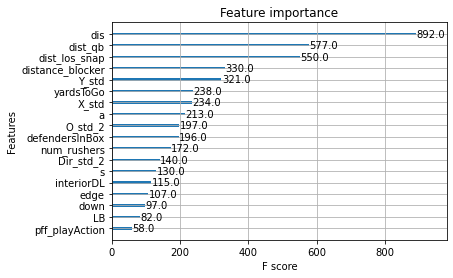

In [82]:
plot_importance(xgb_model)
pyplot.show()

It's interesting to see how important distance to the line of scrimmage at snap is considering the model is making predictions from snap to throw. At the same time, it makes sense because blitzing from 7 yards requires you to run 7 yards before getting close to someone whereas blitzing from 1 yard puts you right into the action at the time of the snap. Yards to go is also in the top 6 most important which makes sense because a longer distance to get the first down allows the pass rushers to pin their ears back and focus on the pass with the run being removed the equation.

In [83]:
final_df.to_csv("C:/Users/19012/Documents/BDB 2023/pressure_predictions.csv")